In [1]:
import os
import sys
from datetime import date
import random
import pandas as pd
from pathlib import Path
import numpy as np

from one.api import ONE

import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchmetrics import AUROC
import lightning as L 
from lightning.pytorch.utilities import CombinedLoader

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)

seed = 666
set_seed(seed)

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/__init__.py:202: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [2]:
# setup
regions = ["LP", "GRN"]
n_sess = 2
out_path = Path("/mnt/3TB/yizi/cached_ibl_data")
one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')

In [103]:
# download and cache data

for roi_idx, roi in enumerate(regions):
    
    print("=================")
    print(f"Downloading data in region {roi} ..")
    
    pids = one.search_insertions(atlas_acronym=[roi], query_type='remote')
    pids = list(pids)[:n_sess]
    
    # load choice
    neural_dict, choice_dict = load_data_from_pids(
        pids,
        brain_region=roi.lower(),
        behavior="choice",
        data_type="all_ks",
        n_t_bins = 40,
    )
    available_pids = list(neural_dict.keys())
    
    # load contrast
    _, contrast_dict = load_data_from_pids(
        pids,
        brain_region=roi.lower(),
        behavior="contrast",
        data_type="good_ks",
        n_t_bins = 40,
    )

    print("=================")
    print(f"Downloaded {len(available_pids)} PIDs in region {roi} ..")
    
    for _, pid in enumerate(available_pids):
        xs, ys = neural_dict[pid], choice_dict[pid]
        n_trials, n_units, n_t_bins = xs.shape
        if n_units < 5:
            continue
        xs = sliding_window_over_trials(xs, half_window_size=0).squeeze()
        ys = sliding_window_over_trials(ys, half_window_size=0).squeeze()
        xs, ys = torch.tensor(xs), torch.tensor(ys)
        
        contrast_dict[pid] = np.nan_to_num(contrast_dict[pid], 0)
        contrast_dict[pid].T[0] *= -1
        contrast = contrast_dict[pid].sum(1)
        
        contrast_mask_dict = {}
        for lvl in np.unique(np.abs(contrast)):
            contrast_mask_dict.update(
                {lvl: np.argwhere(contrast == lvl).flatten()}
            )
            
        path = out_path/roi
        if not os.path.exists(path):
            os.makedirs(path)
            
        data_dict = {}
        data_dict.update({'contrast': contrast})
        data_dict.update({'contrast_mask': contrast_mask_dict})
        data_dict.update({'meta':
            {"n_trials": n_trials, "n_units": n_units, "n_t_bins": n_t_bins}
        })
        xs_per_lvl, ys_per_lvl = {}, {}
        xs_per_lvl.update({"all": xs})
        ys_per_lvl.update({"all": ys})
        for lvl in np.unique(np.abs(contrast)):
            try:
                xs_per_lvl.update({lvl: xs[contrast_mask_dict[lvl]]})
                ys_per_lvl.update({lvl: ys[contrast_mask_dict[lvl]]})
            except:
                continue
        data_dict.update({'neural_contrast': xs_per_lvl})
        data_dict.update({'choice_contrast': ys_per_lvl})
        np.save(path/f"pid_{pid}.npy", data_dict)
        
    print("=================")
    print(f"Successfully cached all data!")

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: ebce500b-c530-47de-8cb1-963c552703ea
pid: 8c732bf2-639d-496c-bf82-464bc9c2d54b
number of trials found: 470
found 470 trials from 13.74 to 5761.52 sec.
found 139 Kilosort units in region lp


Compute spike count: 100%|███████████████████| 470/470 [00:01<00:00, 346.16it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 15b69921-d471-4ded-8814-2adad954bcd8
pid: 7a620688-66cb-44d3-b79b-ccac1c8ba23e
number of trials found: 715
found 715 trials from 28.03 to 3547.82 sec.
found 47 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 715/715 [00:00<00:00, 2892.10it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: ebce500b-c530-47de-8cb1-963c552703ea
pid: 8c732bf2-639d-496c-bf82-464bc9c2d54b
number of trials found: 470
found 470 trials from 13.74 to 5761.52 sec.
found 34 good units in region lp


Compute spike count: 100%|██████████████████| 470/470 [00:00<00:00, 1682.19it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 15b69921-d471-4ded-8814-2adad954bcd8
pid: 7a620688-66cb-44d3-b79b-ccac1c8ba23e
number of trials found: 715
found 715 trials from 28.03 to 3547.82 sec.
found 0 good units in region lp


Compute spike count: 100%|████████████████| 715/715 [00:00<00:00, 108096.72it/s]

Downloaded 2 PIDs in region LP ..
Successfully cached all data!



/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: c958919c-2e75-435d-845d-5b62190b520e
pid: cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
number of trials found: 705
found 705 trials from 79.14 to 3939.10 sec.
found 261 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 705/705 [00:06<00:00, 104.92it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 32d27583-56aa-4510-bc03-669036edad20
pid: 2e720cee-05cc-440e-a24b-13794b1ac01d
number of trials found: 682
found 682 trials from 28.94 to 3431.07 sec.
found 81 Kilosort units in region grn


Compute spike count: 100%|███████████████████| 682/682 [00:02<00:00, 294.69it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: c958919c-2e75-435d-845d-5b62190b520e
pid: cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
number of trials found: 705
found 705 trials from 79.14 to 3939.10 sec.
found 12 good units in region grn


Compute spike count: 100%|██████████████████| 705/705 [00:00<00:00, 1527.49it/s]
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


pulling data from ibl database ..
eid: 32d27583-56aa-4510-bc03-669036edad20
pid: 2e720cee-05cc-440e-a24b-13794b1ac01d
number of trials found: 682
found 682 trials from 28.94 to 3431.07 sec.
found 6 good units in region grn


Compute spike count: 100%|██████████████████| 682/682 [00:00<00:00, 1514.91it/s]


Downloaded 2 PIDs in region GRN ..
Successfully cached all data!


In [56]:
class SessionDataset:
    def __init__(self, dataset, roi_idx, pid_idx, **kargs):
        self.xs, self.ys = dataset
        self.n_trials, self.n_units, _ = self.xs.shape
        self.roi_idx = roi_idx
        self.pid_idx = pid_idx
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, index):
        return self.xs[index], self.ys[index], self.roi_idx, self.pid_idx
    
def dataloader(datasets, roi_idxs, pid_idxs, batch_size=32): 
    loaders = []
    for i, dataset in enumerate(datasets):
        sess_dataset = SessionDataset(dataset, roi_idxs[i], pid_idxs[i])
        loaders.append(DataLoader(
            sess_dataset, batch_size = batch_size
        ))
    return loaders

class Hier_Reduced_Rank_Model(nn.Module):
    def __init__(
        self, 
        n_roi,
        n_units, 
        n_t_bin, 
        rank_V,
        rank_B
    ):
        super(Hier_Reduced_Rank_Model, self).__init__()
        
        self.n_roi = n_roi
        self.n_sess = len(n_units)
        self.n_units = n_units
        self.n_t_bin = n_t_bin
        self.rank_V = rank_V
        self.rank_B = rank_B
        
        self.Us = nn.ParameterList(
            [nn.Parameter(torch.randn(self.n_units[i], self.rank_V)) for i in range(self.n_sess)]
        )
        self.A = nn.Parameter(torch.randn(self.n_roi, self.rank_V, self.rank_B)) 
        self.B = nn.Parameter(
            torch.randn(self.rank_B, self.n_t_bin)
        ) 
        self.intercepts = nn.ParameterList(
            [nn.Parameter(torch.randn(1,)) for i in range(self.n_sess)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, datasets):
        pred_lst, gt_lst = [], []
        for dataset in datasets:
            X, Y, roi_idx, sess_idx = dataset
            roi_idx = torch.unique(roi_idx)
            sess_idx = torch.unique(sess_idx)
            n_trials, n_units, n_t_bins = X.shape
            self.Vs = torch.einsum("ijk,kt->ijt", self.A, self.B)
            Beta = torch.einsum("cr,rt->ct", self.Us[sess_idx], self.Vs[roi_idx].squeeze())
            out = torch.einsum("ct,kct->k", Beta, X)
            out += self.intercepts[sess_idx] * torch.ones(n_trials)
            out = self.sigmoid(out)
            pred_lst.append(out)
            gt_lst.append(Y)
        return pred_lst, gt_lst
    
class LitHierRRR(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch):
        losses = 0
        pred_lst, gt_lst = self.model(batch)
        for i in range(len(batch)):
            losses += nn.BCELoss()(pred_lst[i], gt_lst[i])
        loss = losses / len(batch)
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        metrics = {"val_acc": np.mean(accs), "val_auc": np.mean(aucs)}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        for i in range(len(batch)):
            print(f"session {i} test_acc {accs[i]} test_auc {aucs[i]}")

    def _shared_eval_step(self, batch):
        pred_lst, gt_lst = self.model(batch)
        accs, aucs = [], []
        for i in range(len(batch)):
            auroc = AUROC(task="binary")
            acc = accuracy(pred_lst[i], gt_lst[i], task="binary")
            auc = auroc(pred_lst[i], gt_lst[i])
            accs.append(acc)
            aucs.append(auc)
        return accs, aucs
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-3)
        return optimizer

In [55]:
# setup
regions = ["LP", "GRN"]
n_sess = 2
n_rank_V = 2
n_rank_B = 5
n_epochs = 1000
in_path = Path("/mnt/3TB/yizi/cached_ibl_data")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Started training on trials with contrast all ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 4999: 100%|█████████| 4/4 [00:00<00:00, 68.27it/s, v_num=38, loss=0.00286]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|█████████| 4/4 [00:00<00:00, 63.65it/s, v_num=38, loss=0.00286]


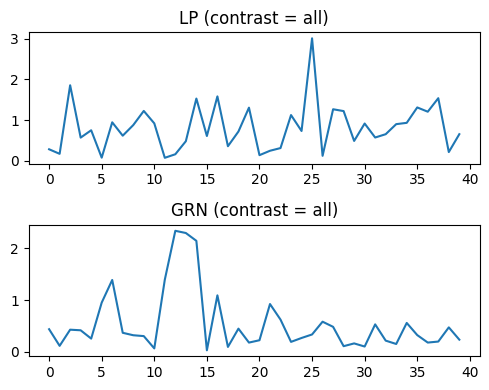

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finished training on trials with contrast all ..
Started training on trials with contrast 0.0625 ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 83.06it/s, v_num=39, loss=1.080]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 61.67it/s, v_num=39, loss=1.080]


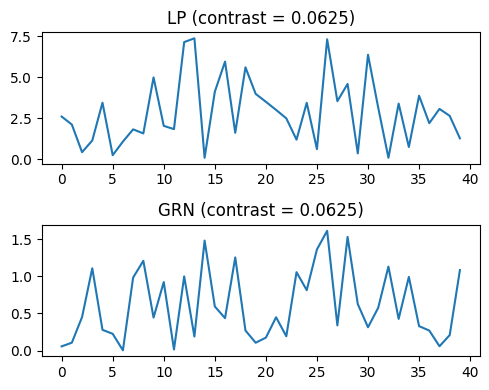

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Finished training on trials with contrast 0.0625 ..
Started training on trials with contrast 0.125 ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 79.26it/s, v_num=40, loss=5.100]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 59.37it/s, v_num=40, loss=5.100]


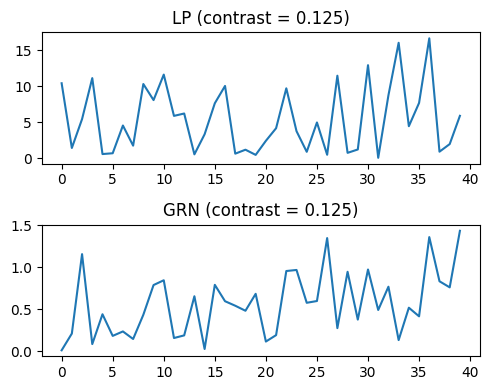

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Finished training on trials with contrast 0.125 ..
Started training on trials with contrast 0.25 ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 80.22it/s, v_num=41, loss=5.880]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 59.20it/s, v_num=41, loss=5.880]


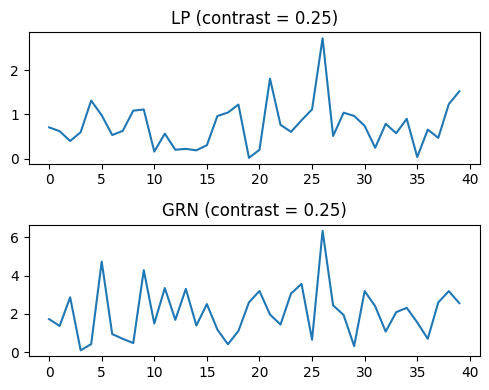

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Finished training on trials with contrast 0.25 ..
Started training on trials with contrast 1.0 ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 10:   0%|                     | 0/1 [00:00<?, ?it/s, v_num=42, loss=44.60]

/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 56. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 81.75it/s, v_num=42, loss=5.610]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|███████████| 1/1 [00:00<00:00, 58.48it/s, v_num=42, loss=5.610]


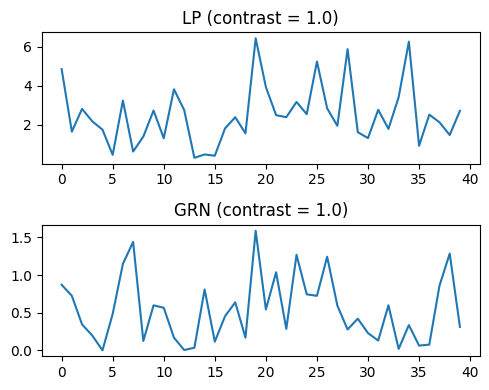

Finished training on trials with contrast 1.0 ..


In [7]:
# prep data for fitting hier-RRR on all trials

res_dict = {}
for lvl in ["all", .0625, .125, .25, 1.]:
    
    print("=================")
    print(f"Started training on trials with contrast {lvl} ..")

    lst_datasets, lst_units, lst_regions, lst_sessions, lst_region_names, lst_pids = [], [], [], [], [], []

    pid_idx = 0
    for roi_idx, roi in enumerate(regions):

        f_names = os.listdir(in_path/roi)
        pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names]

        print("=================")
        print(f"Loading {len(pids)} PIDs in region {roi}:")
        for pid in pids:
            print(pid)

        data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

        for _, pid in enumerate(pids):
            xs = data_dict["neural_contrast"][lvl]
            ys = data_dict["choice_contrast"][lvl]
            lst_datasets.append((xs, ys))
            lst_units.append(data_dict["meta"]["n_units"])
            lst_regions.append(roi_idx)
            lst_region_names.append(roi)
            lst_sessions.append(pid_idx)
            lst_pids.append(pid)
            pid_idx += 1 

    train_loaders = dataloader(lst_datasets, lst_regions, lst_sessions, batch_size=128)
    train_loaders = CombinedLoader(train_loaders, mode="min_size")

    hier_rrr = Hier_Reduced_Rank_Model(
        n_roi = len(regions),
        n_units = lst_units, 
        n_t_bin = data_dict["meta"]["n_t_bins"], 
        rank_V = n_rank_V,
        rank_B = n_rank_B
    )

    lit_hier_rrr = LitHierRRR(hier_rrr)
    trainer = L.Trainer(max_epochs=n_epochs)
    trainer.fit(model=lit_hier_rrr, 
                train_dataloaders=train_loaders)

    Us = [hier_rrr.Us[pid_idx].detach().numpy() for pid_idx in lst_sessions]
    Vs = hier_rrr.Vs.detach().numpy()

    svd_Vs = []
    for pid_idx in lst_sessions:
        roi_idx = lst_regions[pid_idx]
        W = Us[pid_idx] @ Vs[roi_idx]
        U, S, V = svd(W)
        svd_Vs.append(np.diag(S[:n_rank_V]) @ V[:n_rank_V, :])
    svd_Vs = np.array(svd_Vs)
    
    fig, axes = plt.subplots(len(regions), 1, figsize=(5, 2*len(regions)))
    for i, roi_idx in enumerate(np.unique(lst_regions)):
        mask = np.array(lst_regions) == roi_idx
        axes[i].plot(np.abs(svd_Vs[mask].mean(0)[0]))
        axes[i].set_title(f"{regions[roi_idx]} (contrast = {lvl})")
    plt.tight_layout()
    plt.show()

    res_dict.update({lvl: {}})
    res_dict[lvl].update({"pid_idxs": lst_sessions})
    res_dict[lvl].update({"regions_idxs": lst_regions})
    res_dict[lvl].update({"region_names": lst_region_names})
    res_dict[lvl].update({"pids": lst_pids})
    res_dict[lvl].update({"svd_Vs": svd_Vs})
    
    print("=================")
    print(f"Finished training on trials with contrast {lvl} ..")

np.save(in_path/f"res_{date.today()}.npy", res_dict)

In [58]:
# prep data for x-val

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

xval_dict = {}
for fold_idx in range(n_folds):
    
    print("=================")
    print(f"Started training on {fold_idx+1} / {n_folds} folds ..")
    
    train_datasets, test_datasets = [], []
    lst_units, lst_regions, lst_sessions, lst_region_names, lst_pids = [], [], [], [], []

    pid_idx = 0
    for roi_idx, roi in enumerate(regions):

        f_names = os.listdir(in_path/roi)
        pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names]

        print("=================")
        print(f"Loading {len(pids)} PIDs in region {roi}:")
        for pid in pids:
            print(pid)

        data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

        for _, pid in enumerate(pids):
            xs = data_dict["neural_contrast"]["all"]
            ys = data_dict["choice_contrast"]["all"]
            for counter, (train, test) in enumerate(skf.split(xs, ys)):
                if counter == fold_idx:
                    train_xs, test_xs = xs[train], xs[test]
                    train_ys, test_ys = ys[train], ys[test]
            train_datasets.append((train_xs, train_ys))
            test_datasets.append((test_xs, test_ys))
            lst_units.append(data_dict["meta"]["n_units"])
            lst_regions.append(roi_idx)
            lst_region_names.append(roi)
            lst_sessions.append(pid_idx)
            lst_pids.append(pid)
            pid_idx += 1
            
    train_loaders = dataloader(train_datasets, lst_regions, lst_sessions, batch_size=128)
    test_loaders = dataloader(test_datasets, lst_regions, lst_sessions, batch_size=128)
    train_loaders = CombinedLoader(train_loaders, mode="min_size")
    test_loaders = CombinedLoader(test_loaders, mode="min_size")

    hier_rrr = Hier_Reduced_Rank_Model(
        n_roi = len(regions),
        n_units = lst_units, 
        n_t_bin = data_dict["meta"]["n_t_bins"], 
        rank_V = n_rank_V,
        rank_B = n_rank_B
    )

    lit_hier_rrr = LitHierRRR(hier_rrr)
    trainer = L.Trainer(max_epochs=n_epochs)
    trainer.fit(model=lit_hier_rrr, 
                train_dataloaders=train_loaders)
    
    accs_per_batch, aucs_per_batch = [], []
    for batch in test_loaders:
        accs, aucs = [], []
        pred_lst, gt_lst = hier_rrr(batch[0])
        for i in range(len(batch[0])):
            auroc = AUROC(task="binary")
            accs.append(accuracy(pred_lst[i], gt_lst[i], task="binary").item())
            aucs.append(auroc(pred_lst[i], gt_lst[i]).item())
        accs_per_batch.append(accs)
        aucs_per_batch.append(aucs)
    test_accs = np.mean(accs_per_batch, 0)
    test_aucs = np.mean(aucs_per_batch, 0)
    print("Accuracy: ", test_accs)
    print("AUC: ", test_aucs)
    
    xval_dict.update({fold_idx: {}})
    xval_dict[fold_idx].update({"accs": test_accs})
    xval_dict[fold_idx].update({"aucs": test_aucs})
    xval_dict[fold_idx].update({"pid_idxs": lst_sessions})
    xval_dict[fold_idx].update({"regions_idxs": lst_regions})
    xval_dict[fold_idx].update({"region_names": lst_region_names})
    xval_dict[fold_idx].update({"pids": lst_pids})
    
    print("=================")
    print(f"Finished training on {fold_idx+1} / {n_folds} folds ..")

np.save(in_path/f"xval_{date.today()}.npy", xval_dict)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Started training on 0 / 5 folds ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d
Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 65.24it/s, v_num=48, loss=0.00288]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 59.76it/s, v_num=48, loss=0.00288]
Accuracy:  [0.61702126 0.63829786 0.8203125  0.8125    ]
AUC:  [0.68798896 0.69397147 0.90163934 0.91656472]
Finished training on 0 / 5 folds ..
Started training on 1 / 5 folds ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 63.61it/s, v_num=49, loss=0.00313]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 57.16it/s, v_num=49, loss=0.00313]
Accuracy:  [0.60638297 0.60638297 0.8671875  0.8515625 ]
AUC:  [0.6645191  0.65025311 0.96168018 0.94841562]
Finished training on 1 / 5 folds ..
Started training on 2 / 5 folds ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 66.14it/s, v_num=50, loss=0.00397]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 60.50it/s, v_num=50, loss=0.00397]
Accuracy:  [0.64893615 0.67021275 0.890625   0.875     ]
AUC:  [0.70455591 0.70593649 0.9648735  0.96266274]
Finished training on 2 / 5 folds ..
Started training on 3 / 5 folds ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 66.10it/s, v_num=51, loss=0.00357]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 60.46it/s, v_num=51, loss=0.00357]
Accuracy:  [0.53191489 0.54255319 0.8828125  0.9140625 ]
AUC:  [0.59569597 0.61309524 0.9493516  0.96256423]
Finished training on 3 / 5 folds ..
Started training on 4 / 5 folds ..
Loading 2 PIDs in region LP:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
8c732bf2-639d-496c-bf82-464bc9c2d54b
Loading 2 PIDs in region GRN:
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
2e720cee-05cc-440e-a24b-13794b1ac01d


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 1.1 K 
--------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/home/yizi/anaconda3/envs/point_cloud/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 64.70it/s, v_num=52, loss=0.00335]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 59.23it/s, v_num=52, loss=0.00335]
Accuracy:  [0.60638297 0.61702126 0.8046875  0.8046875 ]
AUC:  [0.68681319 0.68681319 0.90318627 0.90073529]
Finished training on 4 / 5 folds ..
